In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

# Compilemos el archivo

In [ ]:
! cd ../genetico && make main_test

In [ ]:
#Definimos los parametros que vamos a usar para las experimentaciones

rows = 6 
cols = 7
c = 4
pieces = 21
amountOfSurvivors = 10
populationSize = 100
games = 50
pc = 0.8
pm = 0.05
t = 0.5
mr = 1.0
pRandomMating = 0.01
fitnessFunction = 1
alpha = 0.5
extinctionRate = 500
generations = 100

#Esto es un helper, no lo borro porque porahi sirve mas adelante, pero no se usa.
callingArgument = str(rows) + ' ' + str(cols) + ' ' + str(c)+ ' ' + str(pieces)+ ' ' + str(amountOfSurvivors)+ ' ' + str(populationSize)+ ' ' + str(games)+ ' ' + str(pc)+ ' ' + str(pm)+ ' ' + str(t)+ ' ' + str(mr)+ ' ' + str(pRandomMating)+ ' ' + str(fitnessFunction)+ ' ' + str(alpha)+ ' ' + str(extinctionRate)+ ' ' + str(generations)
callingArgument

In [ ]:
#Definamos una funcion a la que le pasamos un archivo y si queremos info sobre quien fue el rival. 
#Nos va a graficar la media y la varianza

def graphFitness(fileName, moreInfo,rival):
    dfResultados = pd.read_csv(fileName, delimiter=";")
    dfVariance = dfResultados.groupby('Generation').var()
    dfMean = dfResultados.groupby('Generation').mean()

    ax = dfMean.plot(logy=False)
    ax.set_ylabel("Media de la Fitness")
    ax.set_xlabel("Generacion")    
    title = "Media de la Fitness en funcion de la generacion" + ((" contra un rival " + rival) if moreInfo else "")
    plt.title(title)
    plt.show()


    ax = dfVariance.plot(logy=False)
    ax.set_ylabel("Varianza de la Fitness")
    title = "Varianza de la Fitness en funcion de la generacion" + ((" contra un rival " + rival) if moreInfo else "")
    plt.title(title)
    plt.show()
    
def graphMoves(fileName, moreInfo,rival):
    dfResultados = pd.read_csv(fileName, delimiter=";")
    dfVariance = dfResultados.groupby('Generation').var()
    dfMean = dfResultados.groupby('Generation').mean()

    ax = dfMean.plot(logy=False, figsize=[9,9])
    ax.set_ylabel("Media de la cantidad promedio de jugadas")
    ax.set_xlabel("Generacion")    
    title = "Media de la cantidad de movimientos en funcion de la generacion" + ((" con funcion de fitness: " + rival) if moreInfo else "")
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    plt.title(title)
    plt.show()


#     ax = dfVariance.plot(logy=False)
#     ax.set_ylabel("Varianza de la cantidad promedio de jugadas")
#     title = "Varianza de la cantidad de movimientos en funcion de la generacion" + ((" contra un rival " + rival) if moreInfo else "")
#     plt.title(title)
#     plt.show()

# Versus un rival random

In [ ]:
! RIVAL=RANDOM ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

In [ ]:
graphFitness('./fitness_RANDOM_population25.txt',True,"random")

# Versus un rival de su propia generacion

In [ ]:
! RIVAL=ANCESTORS ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

In [ ]:
graphFitness('./fitness_ANCESTORS_population25.txt',True,"ancestral")

# Versus un minimax acotado

In [ ]:
! RIVAL=MINIMAX ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

In [ ]:
graphFitness('./fitness_MINIMAX_population25.txt',True,"minimax acotado")

# Versus partidos de cada uno: random, ancestors y minimax. Un tercio cada uno

In [ ]:
! RIVAL=MIXED ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

In [ ]:
graphFitness('./fitness_MIXED_population100.txt',True,"minimax acotado")

# Experimentacion Number of Moves

In [ ]:
for i in [1,2]:
    graphMoves('./moves_function{}.txt'.format(i),True,"{}".format(i))

# Experimentacion GridSearch

In [91]:
def makeThemPlay(playerOne, playerTwo):
    !rm -rf ./log && python2 ../juez/c_linea.py\
            --blue_player $playerOne\
            --red_player $playerTwo\
            --iterations 1000\
            --columns 7 --rows 6 --p 21 --c 4 1>/dev/null 2> /dev/null
    
    file  = open('./log/player_communicator_azul.log', 'r').read()
    countBlueWins = file.count('ganaste')/10
    
    file  = open('./log/player_communicator_rojo.log', 'r').read()
    countRedWins = file.count('ganaste')/10
    
    return {
        'playerOneWins': countBlueWins,
        'playerTwoWins': countRedWins
    }


def plot(arr,rival_name):
    time = pd.DataFrame([arr], columns=['Substep 2 Wins', 'Substep 3 Wins', 'Substep 4 Wins','Substep 5 Wins'])
    ax = time.plot(kind='Bar',figsize=[10,10])
    ax.set_ylabel('victorias')
    plt.title("Cantidad de victorias contra {}".format(rival_name))
    plt.show()



In [ ]:
def gridSensei(i):
    return {'path':'../cmake-build-debug/gridSensei_{}'.format(i), 
            'name':'Grid Player Substep {}'.format(i)
           }

catedraPlayer = {'path':'python2 ../juez/PlayerController.py', 'name': 'Jugador de la Catedra'}
geneticPlayer = {'path': '../cmake-build-debug/geneticPlayer','name':'Genetic Player'}
randomPlayer ={'path': '../cmake-build-debug/random_player','name':'Random Player'}

def playAgainstAndPlotIt(rival):
    arr = []
    for i in [2,3,4,5]:
        arr.append(makeThemPlay(gridSensei(i)['path'],rival['path'])['playerOneWins'])

    plot(arr,rival['name'])

playAgainstAndPlotIt(randomPlayer)
playAgainstAndPlotIt(catedraPlayer)
playAgainstAndPlotIt(geneticPlayer)


for i in [2,3,4,5]:
    playAgainstAndPlotIt(gridSensei(i))

    



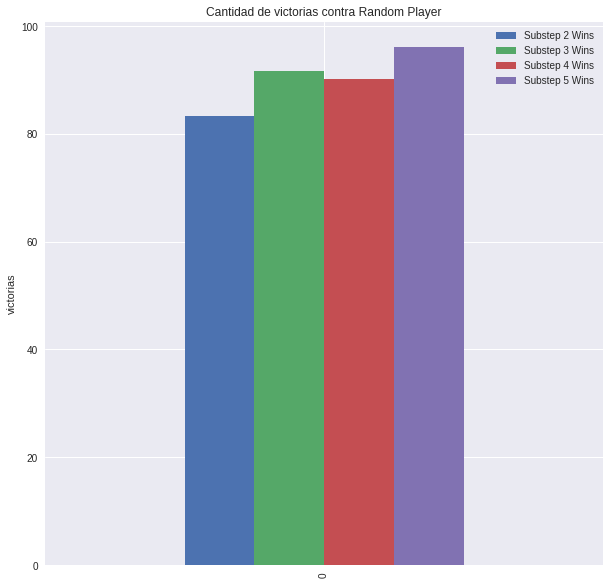

In [97]:
playAgainstAndPlotIt(randomPlayer)

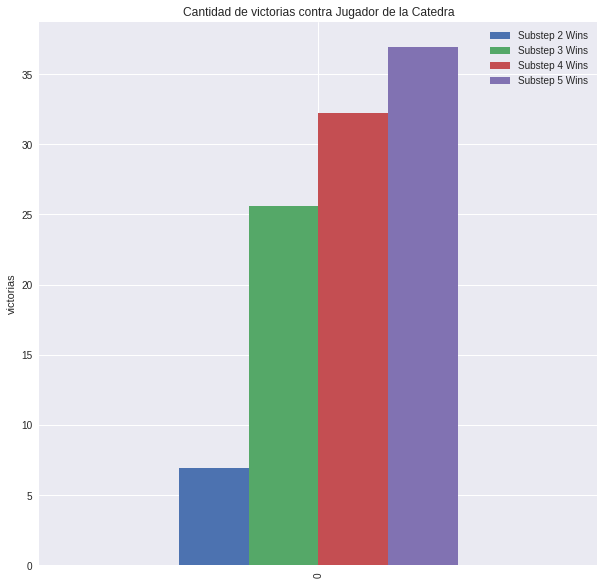

In [98]:
playAgainstAndPlotIt(catedraPlayer)


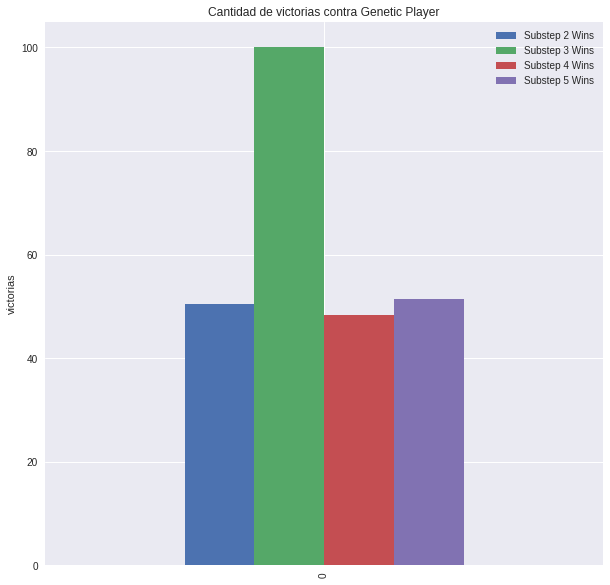

In [99]:
playAgainstAndPlotIt(geneticPlayer)

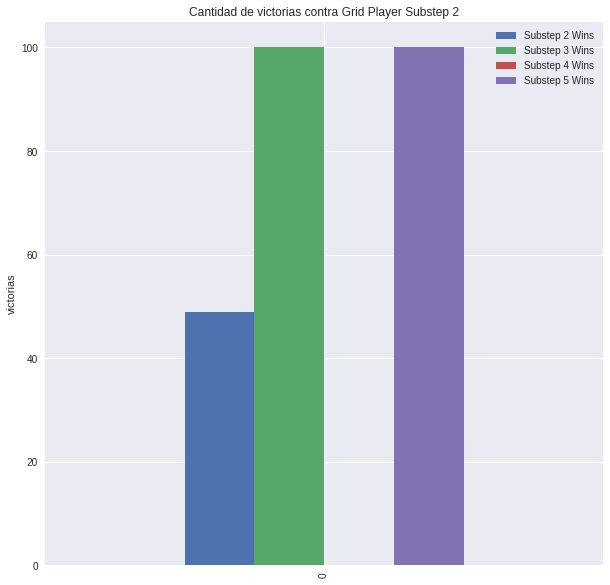

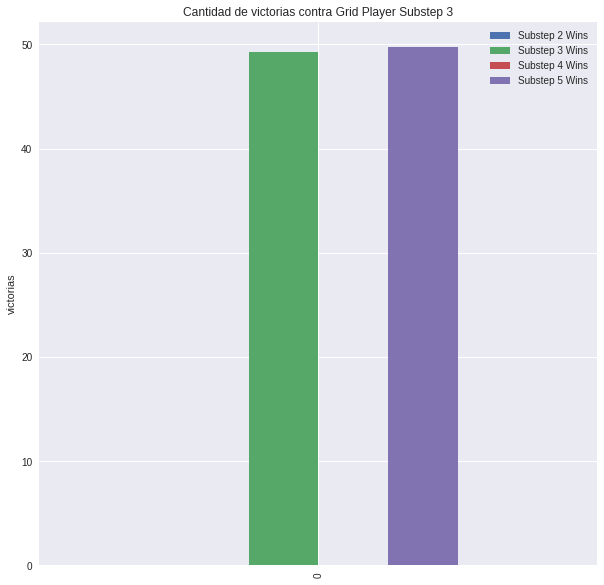

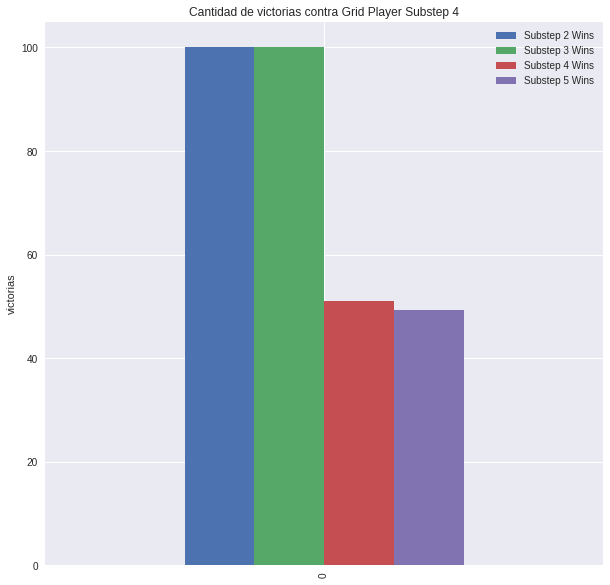

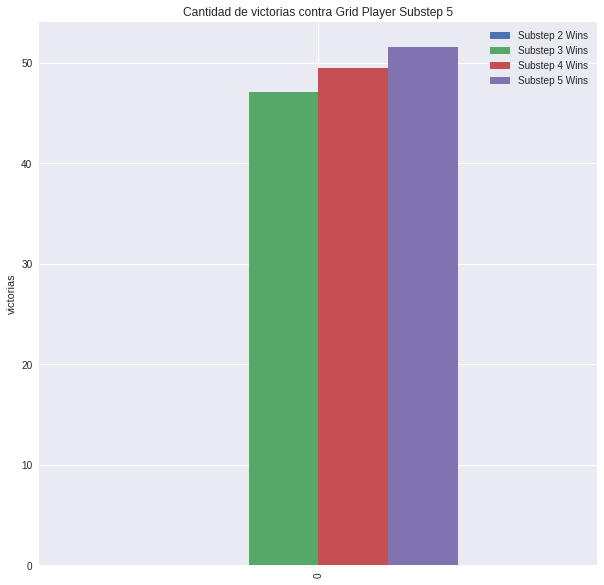

In [100]:
for i in [2,3,4,5]:
    playAgainstAndPlotIt(gridSensei(i))

# Comparar el genetico contra el de la catedra

In [ ]:
def plotBenchmark(arr,rival_name):
    time = pd.DataFrame([arr], columns=['Genetic'])
    ax = time.plot(kind='Bar',figsize=[10,10])
    ax.set_ylabel('victorias')
    plt.title("Cantidad de victorias contra {}".format(rival_name))
    plt.show()
    
arr = []
arr.append(makeThemPlay(geneticPlayer['path'],catedraPlayer['path'])['playerOneWins'])

plotBenchmark(arr,catedraPlayer['name'])